Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 [화자별 예측 결과 요약]

🧑 김소연
- formal(격식있는 말투): 9 문장 (5.62%)
- chat_emoticon(이모티콘 자주 쓰는 말투): 101 문장 (63.12%)
- soft_polite(부드럽고 상냥한 말투): 20 문장 (12.50%)
- elder_speech(어르신 말투): 8 문장 (5.00%)
- informal(친근한 말투): 22 문장 (13.75%)

🧑 유정유정
- formal(격식있는 말투): 9 문장 (4.39%)
- informal(친근한 말투): 35 문장 (17.07%)
- chat_emoticon(이모티콘 자주 쓰는 말투): 141 문장 (68.78%)
- elder_speech(어르신 말투): 13 문장 (6.34%)
- soft_polite(부드럽고 상냥한 말투): 7 문장 (3.41%)


C:\Users\김소연\AppData\Local\Temp\ipykernel_9712\701022462.py:94: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\김소연\ToneDetect\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


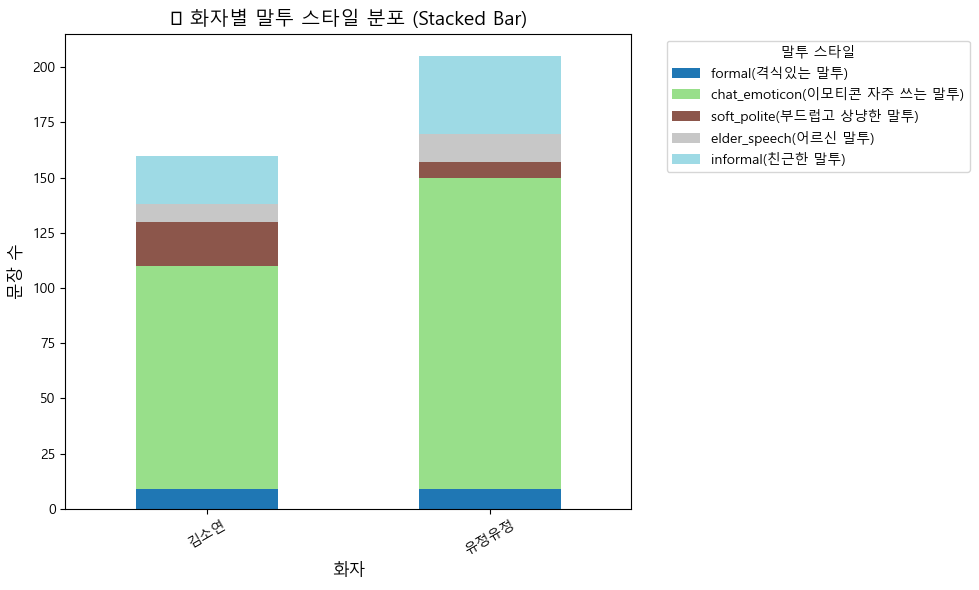

In [3]:
# ✅ 1. 기본 import
import sys
import os
import importlib
import torch
sys.path.append(os.path.join(os.getcwd(), "전처리"))
import merge
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
from collections import defaultdict

plt.rcParams['font.family'] = 'Malgun Gothic'

# ✅ 2. merge.py 실행

import merge  # 전처리 모듈 불러오기

# ✅ 카톡 파일 지정 (변경 가능)
input_chat_path = "uploads/KakaoTalk_20250511_1625_29_658_유정유정.txt"

# ✅ merge 실행 → 정제된 문장 리스트 반환
clean_sentences = merge.run_merge(input_chat_path)  # run_merge() 함수가 merge.py에 있다고 가정

# ✅ 3. 모델 로드
ADAPTER_PATH = "Models/ToneDetect_adapter"
BASE_MODEL_NAME = "beomi/kcbert-base"  # 원래 학습할 때 사용한 베이스

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, num_labels=5)
model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
model.eval()

# ✅ 4. 예측 함수
def predict_style(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=1).item()
    return pred_class

# ✅ 5. 라벨 정의
label_map = {
    0: "chat_emoticon(이모티콘 자주 쓰는 말투)",
    1: "elder_speech(어르신 말투)",
    2: "formal(격식있는 말투)",
    3: "informal(친근한 말투)",
    4: "soft_polite(부드럽고 상냥한 말투)"
}

# ✅ speaker 별 style_counts 초기화
speaker_style_counts = defaultdict(lambda: defaultdict(int))
clean_sentences = merge.run_merge(input_chat_path)

# ✅ 각 문장 예측
for msg in clean_sentences:
    speaker = msg['speaker']
    text = msg['text']
    pred = predict_style(text)
    style_name = label_map[pred]
    speaker_style_counts[speaker][style_name] += 1

# ✅ 결과 출력
print("\n📊 [화자별 예측 결과 요약]")
for speaker, style_counts in speaker_style_counts.items():
    print(f"\n🧑 {speaker}")
    total = sum(style_counts.values())
    for style, count in style_counts.items():
        percent = count / total * 100
        print(f"- {style}: {count} 문장 ({percent:.2f}%)")

# ✅ 8. 시각화 (화자별 stacked bar chart 예시)
import pandas as pd

# DataFrame으로 변환
data = []
for speaker, style_counts in speaker_style_counts.items():
    row = {'speaker': speaker}
    row.update(style_counts)
    data.append(row)

df = pd.DataFrame(data).fillna(0)
df.set_index('speaker', inplace=True)

# 시각화
df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
plt.title("📊 화자별 말투 스타일 분포 (Stacked Bar)", fontsize=14)
plt.xlabel("화자", fontsize=12)
plt.ylabel("문장 수", fontsize=12)
plt.xticks(rotation=30)
plt.legend(title='말투 스타일', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [4]:
from pprint import pprint

pprint(clean_sentences)

[{'order': 0,
  'speaker': '김소연',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 13, 15, 36)},
 {'order': 1,
  'speaker': '유정유정',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 56)},
 {'order': 2,
  'speaker': '유정유정',
  'text': '6,750원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 57)},
 {'order': 3,
  'speaker': '김소연',
  'text': '5,550원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 14, 52)},
 {'order': 4,
  'speaker': '유정유정',
  'text': '5,550원 받기 완료!',
  'timestamp': datetime.datetime(2023, 10, 14, 15, 35)},
 {'order': 5,
  'speaker': '유정유정',
  'text': '6,750원 자동환불 예정',
  'timestamp': datetime.datetime(2023, 10, 17, 11, 35)},
 {'order': 6,
  'speaker': '김소연',
  'text': '6,750원 받기 완료!',
  'timestamp': datetime.datetime(2023, 10, 17, 11, 36)},
 {'order': 7,
  'speaker': '유정유정',
  'text': '언니! 나 유정인데 혹시 도착해써???',
  'timestamp': datetime.datetime(2025, 3, 18, 8, 27)},
 {'order': 8,
  'speaker': '김소연',
  'text': '아

In [5]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "전처리"))  # chat.py가 전처리 폴더에 있을 때
from chat import full_preprocess

# ✅ clean_sentences는 이미 다음 구조로 존재한다고 가정
# clean_sentences = [{"speaker": ..., "text": ..., "timestamp": ..., "order": ...}, ...]

for item in clean_sentences:
    text = item["text"]
    result = full_preprocess(text)

    item["cleaned"] = result["step3_no_emoticons"]
    item["emotion_chunks"] = result["emotion_chunks"]
    item["extracted_emoticons"] = result["extracted_emoticons"]

print("✅ 전처리 완료: 'cleaned', 'emotion_chunks', 'extracted_emoticons' 필드가 추가됨")

✅ 전처리 완료: 'cleaned', 'emotion_chunks', 'extracted_emoticons' 필드가 추가됨


In [6]:
from pprint import pprint

pprint(clean_sentences)

[{'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 0,
  'speaker': '김소연',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 13, 15, 36)},
 {'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 1,
  'speaker': '유정유정',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 56)},
 {'cleaned': '6,750원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 2,
  'speaker': '유정유정',
  'text': '6,750원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 57)},
 {'cleaned': '5,550원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 3,
  'speaker': '김소연',
  'text': '5,550원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 14, 52)},
 {'cleaned': '5,550원 받기 완료',
  'emotion_chunks': {'[강조]': ['!']},
  'extracted_emoticons': [],
  'order': 4,
  'speaker': '유정유정',
  'text': '5,550원 받기 완료!',
  'timestamp': datetime.datetime(2023, 10

In [7]:
from collections import defaultdict, Counter

# 🔹 화자별 감정 문자열 / 이모티콘 카운터 및 예시 저장
speaker_emotion_counter = defaultdict(Counter)
speaker_emotion_examples = defaultdict(lambda: defaultdict(list))

speaker_emo_counter = defaultdict(Counter)
speaker_emo_examples = defaultdict(lambda: defaultdict(list))

for item in clean_sentences:
    speaker = item["speaker"]
    text = item["text"]

    # ✅ 감정 문자열 처리
    already_added_chunks = set()
    for chunk_list in item.get("emotion_chunks", {}).values():
        for chunk in chunk_list:
            speaker_emotion_counter[speaker][chunk] += 1
            if chunk not in already_added_chunks:
                if len(speaker_emotion_examples[speaker][chunk]) < 3 and text not in speaker_emotion_examples[speaker][chunk]:
                    speaker_emotion_examples[speaker][chunk].append(text)
                already_added_chunks.add(chunk)

    # ✅ 이모티콘 처리
    already_added_emoticons = set()
    for emo in item.get("extracted_emoticons", []):
        speaker_emo_counter[speaker][emo] += 1
        if emo not in already_added_emoticons:
            if len(speaker_emo_examples[speaker][emo]) < 3 and text not in speaker_emo_examples[speaker][emo]:
                speaker_emo_examples[speaker][emo].append(text)
            already_added_emoticons.add(emo)

# 🔹 출력
for speaker in sorted(set(speaker_emotion_counter) | set(speaker_emo_counter)):
    print(f"\n🗣️ 화자: {speaker}")

    top_chunks = speaker_emotion_counter[speaker].most_common(3)
    top_emoticons = speaker_emo_counter[speaker].most_common(3)

    # ✅ 감정 문자열 있을 때만 출력
    if top_chunks:
        print("  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):")
        for chunk, count in top_chunks:
            print(f"    - {chunk}: {count}회")
            for example in speaker_emotion_examples[speaker][chunk]:
                print(f"        예시: {example}")

    # ✅ 이모티콘 있을 때만 출력
    if top_emoticons:
        print("  🔸 가장 많이 쓴 이모티콘 (extracted_emoticons):")
        for emo, count in top_emoticons:
            print(f"    - {emo}: {count}회")
            for example in speaker_emo_examples[speaker][emo]:
                print(f"        예시: {example}")



🗣️ 화자: 김소연
  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):
    - !: 25회
        예시: 6,750원 받기 완료!
        예시: 나 방금 끝나서 가는 중!
        예시: 모델은 용량이 커서 깃허브에 안올라가지길래 압축 파일로 보낼겡! 같은 폴더에 넣어서 predict파일만 돌려바바
    - ~: 23회
        예시: 아닝 나 50분쯤 도착할듯~
        예시: 웅웅~
        예시: 웅웅 오늘 저녁까지 해서 보내줄겡~
    - !!: 16회
        예시: 오옹 고생해써!!
        예시: 웅웅 천천히 해!!
        예시: 아구 다행이다ㅠㅠ 미리 알려줄걸 그랬당... 까먹구있었더... 고생했어!!

🗣️ 화자: 유정유정
  🔸 가장 많이 쓴 감정 표현 문자열 (emotion_chunks):
    - !!: 31회
        예시: 나 달구지 타고 가고이써!! 도착해서 자리 잡아둘게 ㅎㅎ
        예시: 헉!!
        예시: 웅!! 조아용~~
    - ??: 26회
        예시: 어모 지금은 어디쯤야??
        예시: 언니 혹시 끝났어??
        예시: 언니 어제 새벽에 과제에 대해서 올라왔더라구 내가 1번은 거의 다 했거덩?? 그래서 정리만 하면 거의 완성인데 2번은 내가 책이 없어서 확인이 어려운데 혹시 시간되면 교재로 해당 페이지 확인해줄 수 있어??
    - ...: 22회
        예시: ㅎㅎ 언니 미안... 또 앞자리얌...
        예시: 저번에 앉았던 그 자리...^^
        예시: 아니 실습도 많다고 했는데 할 수는 있냐구요...
  🔸 가장 많이 쓴 이모티콘 (extracted_emoticons):
    - 🥰: 2회
        예시: 일단 페이지 새로 팠어!! 전에 건 너무 뭐가 안 되가지고 아예 새로 파서 초대까지 했는데 초대 됐는지 확인해주세용 🥰
        예시: 어머

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ✅ 모델 & 토크나이저 불러오기
MODEL_PATH = "Models/pko-t5-finetuned-chat"  # 너가 학습한 경로
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ 정제 함수 정의
def refine_with_model(text: str) -> str:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # ✅ 수정된 부분

    # model.generate에 no_repeat_ngram_size 파라미터 추가
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,  # 길이 제한 OK
            no_repeat_ngram_size=2,  # 2-gram 이상 반복을 방지
        )
    refined = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return refined.strip()

In [9]:
for item in clean_sentences:
    cleaned_text = item.get("cleaned", "")
    if cleaned_text:
        try:
            item["refined"] = refine_with_model(cleaned_text)
        except Exception as e:
            print(f"❗ '{cleaned_text}' 정제 중 오류 발생:", e)
            item["refined"] = ""  # 실패 시 빈 문자열로 표시

print("✅ 모든 cleaned 문장에 대해 refined 결과 추가 완료")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


✅ 모든 cleaned 문장에 대해 refined 결과 추가 완료


In [10]:
from pprint import pprint

pprint(clean_sentences)

[{'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 0,
  'refined': '정산하기를 요청했어요.',
  'speaker': '김소연',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 13, 15, 36)},
 {'cleaned': '정산하기를 요청했어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 1,
  'refined': '정산하기를 요청했어요.',
  'speaker': '유정유정',
  'text': '정산하기를 요청했어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 56)},
 {'cleaned': '6,750원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 2,
  'refined': '6, 750원을 보냈어요.',
  'speaker': '유정유정',
  'text': '6,750원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 12, 57)},
 {'cleaned': '5,550원을 보냈어요.',
  'emotion_chunks': {},
  'extracted_emoticons': [],
  'order': 3,
  'refined': '5, 550원을 보냈어요.',
  'speaker': '김소연',
  'text': '5,550원을 보냈어요.',
  'timestamp': datetime.datetime(2023, 10, 14, 14, 52)},
 {'cleaned': '5,550원 받기 완료',
  'emotion_chunks': {'[강조]': ['!']},
  'extracted

In [11]:
import datetime
from konlpy.tag import Okt
from gensim import corpora
from gensim.models import LdaModel

# ✅ 예시 데이터 (실제에서는 이미 clean_sentences 리스트로 존재)
# clean_sentences = [{'refined': '정산하기를 요청했어요.', ... }, {...}, ...]

# ✅ 1. refined 문장만 추출
texts = [item['refined'] for item in clean_sentences if item.get('refined') and item['refined'].strip()]

# ✅ 2. 형태소 분석기 사용해 명사만 추출
okt = Okt()
tokenized_texts = [okt.nouns(text) for text in texts]

# ✅ 3. Dictionary 및 Corpus 생성
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# ✅ 4. LDA 모델 학습
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,       # 원하는 토픽 수 설정
    passes=10,          # 학습 반복 횟수
    random_state=42     # 재현성 확보
)

# ✅ 5. 토픽 출력
print("📌 추출된 주요 토픽:")
topics = lda_model.print_topics(num_words=5)
for i, topic in topics:
    print(f"🧩 토픽 {i+1}: {topic}")

SystemError: java.lang.UnsatisfiedLinkError: C:\Users: Can't find dependent libraries